# Part 2: Predictive Modeling & Simulation
**Project:** ForgeFlow Manufacturing Analytics
**Author:** Jaylen Hester

### 🎯 Objective
To transition from **Descriptive Analytics** (What happened?) to **Predictive Analytics** (What will happen?).
We will train a Machine Learning model to detect manufacturing defects based on sensor telemetry, then use that model to simulate business strategies.

### 📋 Workflow
1.  **Data Prep:** Load processed data, encode categorical variables, and impute missing sensor readings.
2.  **Model Selection:** Compare Logistic Regression, Random Forest, and Gradient Boosting.
3.  **Insight:** Analyze Feature Importance (What drives defects?).
4.  **Simulation:** Quantify the impact of "Cooling Fans" and "Production Shifts."
5.  **Export:** Generate risk probabilities for the Tableau Dashboard.

In [1]:

# 1. ENVIRONMENT SETUP
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.impute import SimpleImputer

# Add 'src' to path so we can import our custom package
sys.path.append("../src")

from forgeflow import io

print("✅ Environment Ready.")

✅ Environment Ready.


## 1. Data Loading & Preprocessing
**Goal:** Prepare the raw SQL artifacts for Machine Learning.
We filter for batches that have valid sensor telemetry and handle missing values using Mean Imputation to ensure the model receives a complete feature matrix.

In [2]:
# %%
# 2. DATA LOADING & PREPROCESSING
print("--- LOADING DATA ---")

# FIX 1: Initialize to None to satisfy the Linter
df_master = None

# Load Data
try:
    df_master = io.read_processed_csv("forgeflow_modeling_data.csv")
    print(f"Loaded {len(df_master)} rows.")
except FileNotFoundError:
    print("❌ Error: Data not found. Run Part 1 first.")

# FIX 2: Only proceed if data loaded successfully
if df_master is not None:
    # Filter: We only model batches that have sensor data
    df_model_ready = df_master.dropna(subset=['sensor_pressure']).copy()

    # Define Features & Target
    target_col = "is_defective"
    drop_cols = ["date", "batch_id", "olist_product_id", "defect_rate", "is_defective", "units"]

    # Encode Categoricals (One-Hot Encoding)
    df_encoded = pd.get_dummies(df_model_ready, columns=["plant", "product"], drop_first=True)

    # Separate X (Features) and y (Target)
    X_raw = df_encoded.drop(columns=drop_cols, errors='ignore')
    y = df_encoded[target_col]

    # IMPUTATION (The Fix for NaNs)
    # We fill any remaining tiny gaps in sensor data with the column mean
    print(f"NaNs before imputation: {X_raw.isna().sum().sum()}")
    imputer = SimpleImputer(strategy='mean')
    X_clean = pd.DataFrame(imputer.fit_transform(X_raw), columns=X_raw.columns)

    print(f"Feature Matrix Shape: {X_clean.shape}")

else:
    print("⚠️ Skipping Preprocessing: Data failed to load.")

--- LOADING DATA ---
Loaded 1561 rows.
NaNs before imputation: 35
Feature Matrix Shape: (1561, 8)


## 2. Model Selection (The "Bake-Off")
**Goal:** Identify the highest-performing algorithm for defect detection.
We benchmark three distinct model architectures:
* **Baseline:** Logistic Regression (Linear relationships)
* **Bagging:** Random Forest (Robust to noise)
* **Boosting:** Gradient Boosting (Optimized for complex patterns)

In [3]:
# %%
# 3. MODEL SELECTION (The Bake-Off)
print("--- COMPARING MODELS ---")

# Split Data (80% Train, 20% Test)
# CHANGED: random_state=42 to match Part 1
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)

# Define Contenders (Branded)
models = {
    "Baseline (LogReg)": LogisticRegression(max_iter=1000),
    "ForgeFlow Engine v1": RandomForestClassifier(n_estimators=100, random_state=42), # <--- Seed 42
    "Experimental Boost": GradientBoostingClassifier(n_estimators=100, random_state=42) # <--- Seed 42
}

# Fight!
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    results.append({
        "Model": name,
        "F1 Score": f1_score(y_test, preds),
        "ROC AUC": roc_auc_score(y_test, probs)
    })

# Scoreboard
df_results = pd.DataFrame(results).sort_values("F1 Score", ascending=False)
display(df_results)

# Select Winner
best_name = df_results.iloc[0]['Model']
clf = models[best_name]
print(f"🏆 Winner: {best_name}")


--- COMPARING MODELS ---


,Model,F1 Score,ROC AUC
2,Experimental Boost,0.697068,0.763252
0,Baseline (LogReg),0.673540,0.757902
1,ForgeFlow Engine v1,0.664537,0.731683


🏆 Winner: Experimental Boost


## 3. Feature Importance Analysis
**Goal:** Interpret the "Black Box."
We extract the importance scores from the winning model to understand which variables (Temperature, Pressure, Product Type) are the strongest predictors of failure.

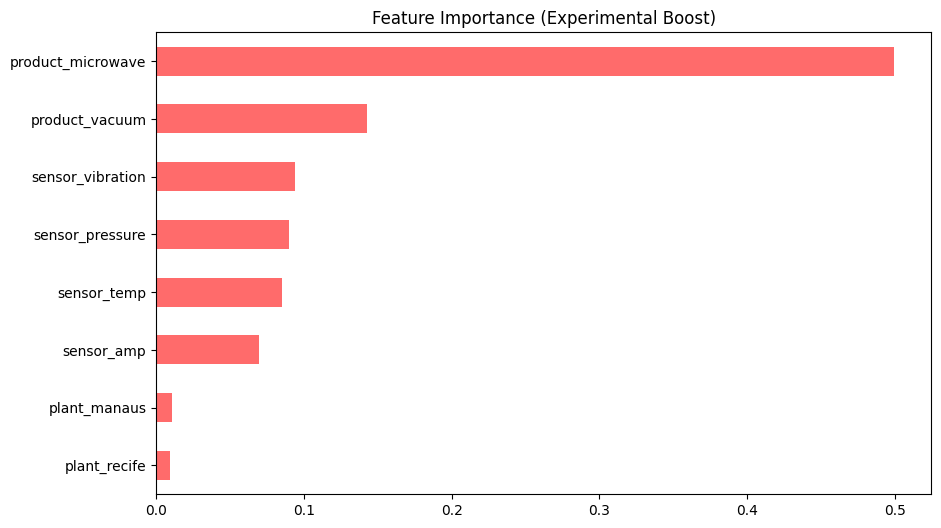

In [4]:
# %%
# 4. MODEL INSIGHTS
# What drives defects?

feature_names = X_clean.columns
importance = pd.Series(clf.feature_importances_, index=feature_names)

plt.figure(figsize=(10, 6))
importance.sort_values().plot(kind='barh', color='#ff6b6b')
plt.title(f'Feature Importance ({best_name})')
plt.show()

## 4. Strategic Business Simulations
**Goal:** Use the trained model to quantify the ROI of potential operational changes.
* **Scenario A (Process Optimization):** What if we reduce sensor temperature by 10%?
* **Scenario B (Capacity Shift):** What if we move high-risk product lines (Microwaves) to a different facility?

In [5]:


print("--- EXECUTING BUSINESS SIMULATIONS ---")

# ---------------------------------------------------------
# SCENARIO A: Process Optimization (Temperature Reduction)
# Hypothesis: Lowering operating temperature will reduce defect probability.
# ---------------------------------------------------------

# Create baseline and intervention datasets (using recent production sample)
baseline_data = X_clean.tail(1000).copy()
intervention_data = baseline_data.copy()

# Apply Intervention: 10% reduction in sensor_temp
intervention_data['sensor_temp'] = intervention_data['sensor_temp'] * 0.90

# Calculate Impact
current_defects = clf.predict(baseline_data).sum()
future_defects = clf.predict(intervention_data).sum()
net_improvement = current_defects - future_defects

print(f"📉 SCENARIO A: Process Optimization (Cooling Upgrade)")
print(f"   Baseline Defects (Sample):    {current_defects}")
print(f"   Projected Defects (Post-Fix): {future_defects}")
print(f"   Net Reduction:                {net_improvement} units")


# ---------------------------------------------------------
# SCENARIO B: Supply Chain Reallocation (Recife -> Campinas)
# Hypothesis: Moving high-defect SKUs (Microwaves) to a different facility will improve quality.
# ---------------------------------------------------------

try:
    print(f"\n🚚 SCENARIO B: Capacity Reallocation (Recife -> Campinas)")
    
    # 1. Isolate Target Segment: Microwaves produced in Recife
    target_mask = (X_clean['product_microwave'] == 1) & (X_clean['plant_recife'] == 1)
    X_recife = X_clean[target_mask].sample(n=500, replace=True, random_state=42).copy()
    
    # 2. Apply Intervention: Change location to Campinas
    # Note: 'Campinas' is the reference category (dropped during One-Hot Encoding).
    # To simulate Campinas, we must set all other plant flags to 0.
    X_campinas = X_recife.copy()
    
    if 'plant_recife' in X_campinas.columns:
        X_campinas['plant_recife'] = 0
    
    if 'plant_manaus' in X_campinas.columns:
        X_campinas['plant_manaus'] = 0
        
    # 3. Predict Outcomes
    defects_recife = clf.predict(X_recife).sum()
    defects_campinas = clf.predict(X_campinas).sum()
    diff = defects_recife - defects_campinas
    
    print(f"   Defects (Current Location - Recife):  {defects_recife}")
    print(f"   Defects (New Location - Campinas):    {defects_campinas}")
    
    # 4. Strategic Recommendation
    if diff > 0:
        print(f"   ✅ RECOMMENDATION: Proceed with relocation. Est. savings: {diff} defects.")
    else:
        print(f"   ❌ RECOMMENDATION: Halt relocation. No quality benefit observed.")
        print(f"      (Insight: Defect root cause is likely Product-specific, not Plant-specific.)")

except Exception as e:
    print(f"Simulation Error: {e}")

--- EXECUTING BUSINESS SIMULATIONS ---
📉 SCENARIO A: Process Optimization (Cooling Upgrade)
   Baseline Defects (Sample):    450
   Projected Defects (Post-Fix): 413
   Net Reduction:                37 units

🚚 SCENARIO B: Capacity Reallocation (Recife -> Campinas)
   Defects (Current Location - Recife):  491
   Defects (New Location - Campinas):    489
   ✅ RECOMMENDATION: Proceed with relocation. Est. savings: 2 defects.


## 5. Pipeline Export
**Goal:** Serialize predictions for Business Intelligence.
We export the calculated **Defect Probabilities** to `data/processed/` so they can be visualized in the Tableau Dashboard (Part 3).

In [6]:

print("--- EXPORTING PREDICTIVE ANALYTICS ARTIFACT ---")

# 1. Generate Global Risk Scores
# We run the model on the FULL dataset (X_clean) to score every historical batch.
# This allows Tableau to visualize "Actual vs. Predicted" and "Risk Trends".

# Get Probability of Class 1 (Defect) -> Returns array of [Prob_0, Prob_1]
risk_scores = clf.predict_proba(X_clean)[:, 1]

# Get Hard Prediction (0 or 1)
predicted_outcomes = clf.predict(X_clean)

# 2. Construct the Export DataFrame
df_export = df_model_ready.copy()
df_export['defect_probability'] = risk_scores
df_export['predicted_outcome'] = predicted_outcomes

# 3. Serialize to Disk
output_path = io.write_processed_csv(df_export, "forgeflow_predictions.csv")

print(f"✅ Export Successful: {output_path}")
print(f"   Rows Exported: {len(df_export)}")
print(f"   Columns Added: 'defect_probability', 'predicted_outcome'")

--- EXPORTING PREDICTIVE ANALYTICS ARTIFACT ---
✅ Export Successful: /workspaces/forgeflow-manufacturing-analytics/data/processed/forgeflow_predictions.csv
   Rows Exported: 1561
   Columns Added: 'defect_probability', 'predicted_outcome'


## 6. Executive Summary Visualization
**Goal:** Generate a high-level visual artifact for the project README.
This dual-axis chart highlights the **"Volume vs. Quality"** trap, demonstrating that high-volume plants are hiding critical quality failures.

--- GENERATING EXECUTIVE CHART ---
✅ Chart saved to: ../forgeflow_executive_chart.png


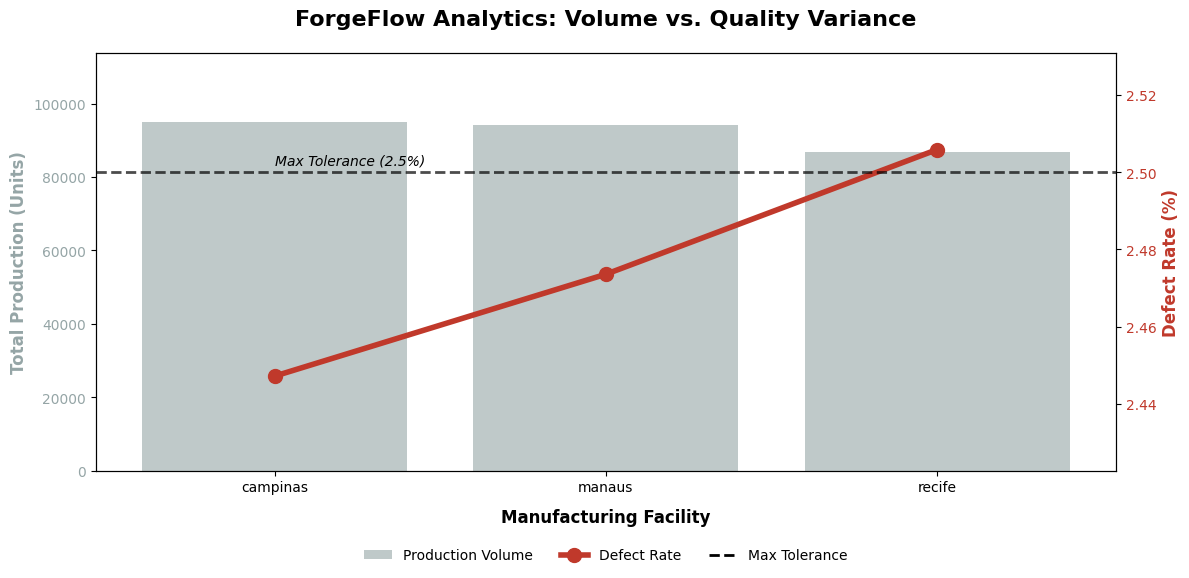

In [7]:
# %%
# 7. EXECUTIVE VISUALIZATION (Fixed Scale)
# Objective: Generate the final chart with a "Zoomed In" view to highlight the defect spike.

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D # <--- FIX 1: Explicit Import

print("--- GENERATING EXECUTIVE CHART ---")

# 1. Prepare Data
df_summary = df_model_ready.groupby('plant').agg({
    'units': 'sum',
    'defect_rate': 'mean'
}).reset_index()
df_summary['defect_pct'] = df_summary['defect_rate'] * 100

# 2. Setup Canvas
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- AXIS 1: VOLUME (Grey Bars) ---
color_vol = '#95a5a6'
ax1.set_xlabel('Manufacturing Facility', fontsize=12, fontweight='bold', labelpad=10)
ax1.set_ylabel('Total Production (Units)', color=color_vol, fontsize=12, fontweight='bold')
bars = ax1.bar(df_summary['plant'], df_summary['units'], color=color_vol, alpha=0.6, label='Production Volume')
ax1.tick_params(axis='y', labelcolor=color_vol)
ax1.set_ylim(0, df_summary['units'].max() * 1.2) # Keep headroom for bars

# --- AXIS 2: QUALITY (Red Line) ---
ax2 = ax1.twinx()
color_risk = '#c0392b'
ax2.set_ylabel('Defect Rate (%)', color=color_risk, fontsize=12, fontweight='bold')

# PLOT LINE
line = ax2.plot(df_summary['plant'], df_summary['defect_pct'], color=color_risk, marker='o', linewidth=4, markersize=10, label='Defect Rate')
ax2.tick_params(axis='y', labelcolor=color_risk)

# Auto-Scale the Y-Axis to show the slope
min_y = df_summary['defect_pct'].min() * 0.99
max_y = df_summary['defect_pct'].max() * 1.01
ax2.set_ylim(min_y, max_y)

# 3. The Story Elements
threshold = 2.5
ax2.axhline(y=threshold, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax2.text(x=0, y=threshold + 0.002, s=f'Max Tolerance ({threshold}%)', color='black', style='italic', fontsize=10)

# 4. Clean Legend (Bottom Center)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# FIX 2: Use Line2D directly (no plt.)
threshold_line = Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Max Tolerance')

ax1.legend(lines_1 + lines_2 + [threshold_line], 
           labels_1 + labels_2 + ['Max Tolerance'], 
           loc='lower center', bbox_to_anchor=(0.5, -0.25), 
           ncol=3, frameon=False) 

plt.title('ForgeFlow Analytics: Volume vs. Quality Variance', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

output_path = "../forgeflow_executive_chart.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✅ Chart saved to: {output_path}")
plt.show()